In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from simulation import simulation
from optimization import OptimizationManager
from emulation import Emulator
from config import (
    WAVE_FREQ, WAVE_SPEED, WAVE_DECAY, WAVE_CUTOFF, WAVE_RETREAT_COEFF, WAVE_HEIGHT,
    SAND_PULL, GROUND_PULL, WATER_DECAY, WAVE_VOL, WAVE_AMPLITUDE, WAVE_SPREAD,
    DIM_MAP, OBSTACLE_COORDS
)

First, we set up the simulation.

In [3]:
# Sim parameters
SIM_PARAMS = {
    "wave_freq": WAVE_FREQ,
    "wave_speed": WAVE_SPEED,
    "wave_decay": WAVE_DECAY,
    "wave_cutoff": WAVE_CUTOFF,
    "wave_retreat_coeff": WAVE_RETREAT_COEFF,
    "wave_height": WAVE_HEIGHT,
    "sand_pull": SAND_PULL,
    "ground_pull": GROUND_PULL,
    "water_decay": WATER_DECAY,
    "wave_vol": WAVE_VOL,
    "wave_amplitude": WAVE_AMPLITUDE,
    "wave_spread": WAVE_SPREAD,
}

Some helper functions to visualize the results of the optimized placement of barriers

In [4]:
# Helper function for erosion heatmap
def plot_erosion_heatmap(before_map, after_map, title, cmap='Reds'):
    sand_before = before_map[:, :, 1]  # Sand layer before erosion
    sand_after = after_map[:, :, 1]    # Sand layer after erosion
    erosion_diff = sand_before - sand_after  # Difference in sand levels

    plt.imshow(erosion_diff, cmap=cmap)
    plt.colorbar(label="Erosion Intensity")
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")

# Helper function for numerical erosion values
def calculate_total_erosion(before_map, after_map):
    sand_before = before_map[:, :, 1]
    sand_after = after_map[:, :, 1]
    total_erosion = np.sum(sand_before - sand_after)
    return total_erosion

Then we run the simulation first without any barriers, then with randomly placed barriers, and eventually we run an optimization using Bayesian Opt. to obtain optimal coordinates of the barriers and use that to generate final simulation results.

In [5]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# 1. Run simulation without barriers
print("\nRunning simulation without barriers...")
sim_no_barrier = simulation(**SIM_PARAMS, obstacle_coords=[], erosion_speedup=100, dim_map=DIM_MAP)
before_map_no_barrier, after_map_no_barrier, before_erosion_no_barrier, after_erosion_no_barrier = sim_no_barrier.run_sim(num_timesteps=1000)

print(f"Change in erosion (no barriers): {after_erosion_no_barrier - before_erosion_no_barrier}\n")

# 2. Run simulation with non-optimized barriers
print("\nRunning simulation with non-optimized barriers...")
sim_non_optimized = simulation(**SIM_PARAMS, obstacle_coords=OBSTACLE_COORDS, erosion_speedup=100, dim_map=DIM_MAP)
before_map_non_optimized, after_map_non_optimized, before_erosion_non_optimized, after_erosion_non_optimized = sim_non_optimized.run_sim(num_timesteps=1000)

print(f"Change in erosion (non-optimized barriers): {after_erosion_non_optimized - before_erosion_non_optimized}\n")


Running simulation without barriers...


  0%|          | 0/999 [00:00<?, ?it/s]

Change in erosion (no barriers): 1143


Running simulation with non-optimized barriers...


  0%|          | 0/999 [00:00<?, ?it/s]

Change in erosion (non-optimized barriers): 1885



In [8]:

# 3. Optimize barrier placement
print("\nOptimizing barrier placement...")

def run_optimization(num_timesteps=100, n_samples=20, n_iterations=20):
    emulator = Emulator()
    opt_manager = OptimizationManager(emulator=emulator)
    param_samples = opt_manager.sample_parameters(n_samples)
    
    outcomes = []
    for params in param_samples:
        outcomes.append(opt_manager.wrapped_run_sim(params))
    
    # Convert results to numpy arrays
    X = np.array(param_samples)
    Y = np.array(outcomes).reshape(-1, 1)
    
    # Run Bayesian optimization
    loop_state = opt_manager.run_optimization(X, Y, n_iterations=n_iterations)
    
    # Extract the best parameters
    best_parameters = loop_state.X[-1]
    return [(best_parameters[i], best_parameters[len(OBSTACLE_COORDS) + i]) for i in range(len(OBSTACLE_COORDS))]

optimized_coords = run_optimization()
print(f"Optimized barrier coordinates: {optimized_coords}")

# 4. Run simulation with optimized barriers
print("\nRunning simulation with optimized barriers...")
sim_optimized = simulation(**SIM_PARAMS, obstacle_coords=optimized_coords, erosion_speedup=100, dim_map=DIM_MAP)
before_map_optimized, after_map_optimized, before_erosion_optimized, after_erosion_optimized = sim_optimized.run_sim(num_timesteps=1000)

print(f"Change in erosion (optimized barriers): {after_erosion_optimized - before_erosion_optimized}\n")


Optimizing barrier placement...


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Optimized barrier coordinates: [(2.4797773738471807, 83.01541385725776)]

Running simulation with optimized barriers...


  0%|          | 0/999 [00:00<?, ?it/s]

Change in erosion (optimized barriers): 4452



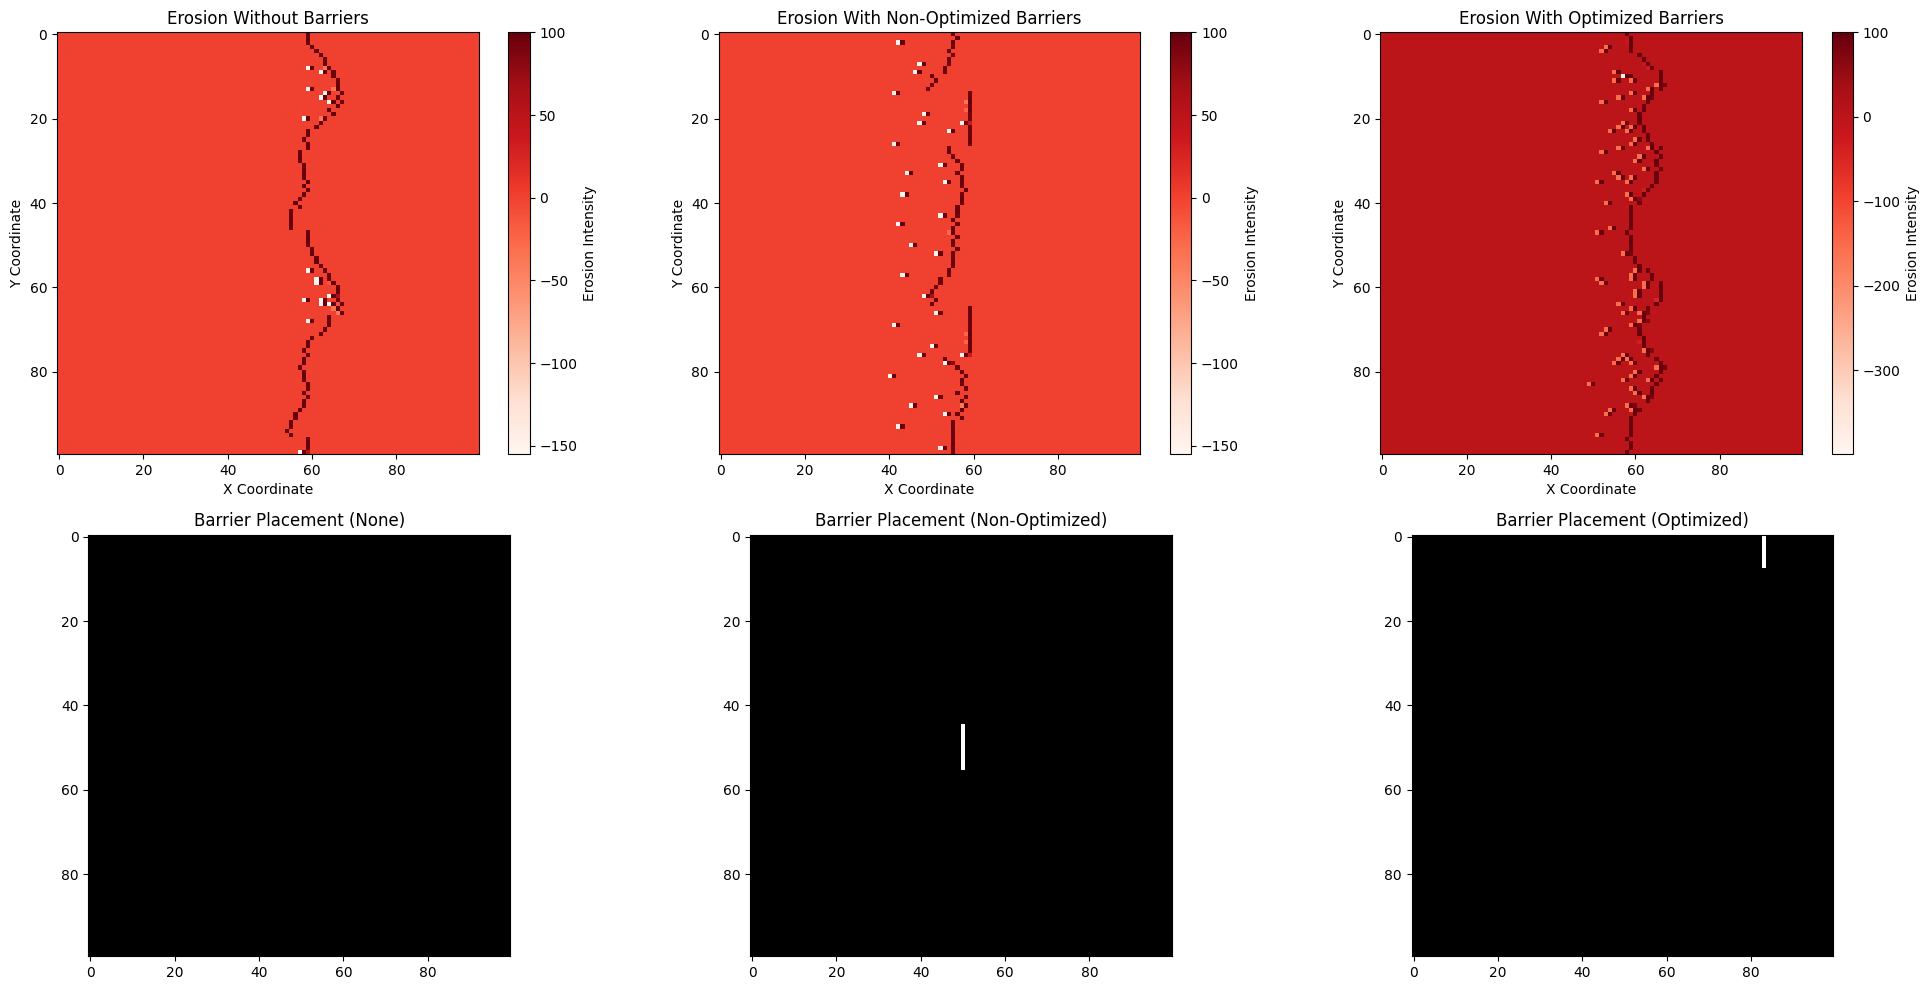

In [9]:

# 5. Visualize results
plt.figure(figsize=(20, 10))

# Without barriers
plt.subplot(2, 3, 1)
plot_erosion_heatmap(before_map_no_barrier, after_map_no_barrier, "Without Barriers")
plt.title("Erosion Without Barriers")

plt.subplot(2, 3, 4)
sim_no_barrier.place_obstacles()
plt.imshow(sim_no_barrier.obstacle_map, cmap='gray')
plt.title("Barrier Placement (None)")

# Non-optimized barriers
plt.subplot(2, 3, 2)
plot_erosion_heatmap(before_map_non_optimized, after_map_non_optimized, "Non-Optimized Barriers")
plt.title("Erosion With Non-Optimized Barriers")

plt.subplot(2, 3, 5)
sim_non_optimized.place_obstacles()
plt.imshow(sim_non_optimized.obstacle_map, cmap='gray')
plt.title("Barrier Placement (Non-Optimized)")

# Optimized barriers
plt.subplot(2, 3, 3)
plot_erosion_heatmap(before_map_optimized, after_map_optimized, "Optimized Barriers")
plt.title("Erosion With Optimized Barriers")

plt.subplot(2, 3, 6)
sim_optimized.place_obstacles()
plt.imshow(sim_optimized.obstacle_map, cmap='gray')
plt.title("Barrier Placement (Optimized)")

plt.tight_layout()
plt.show()

Now that we have the optimal barrier coords, let's run a simulation in 3D

  0%|          | 0/19 [00:00<?, ?it/s]

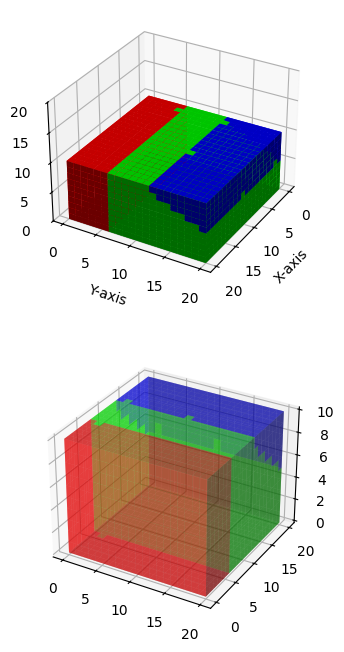

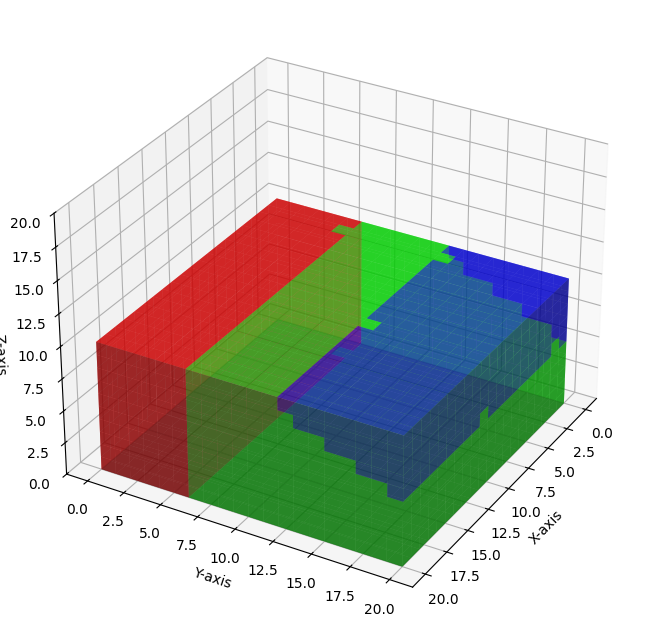

In [7]:
from simulation3D import Simulation3D

sim_3d = Simulation3D(**SIM_PARAMS, obstacle_coords=[], dim_map=20)

coast_map_init, coast_map_3D, initial_sand, final_sand = sim_3d.run_sim(num_timesteps=20)
sim_3d.plot_3d_downsamp(red_dim=20)
sim_3d.plot_3d()